In [156]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Preprossesering av rentedataen
Ettersom dato-kolonnene er ulike for ulike rente-perioder så må vi først justere for dette.

In [157]:
df = pd.read_excel(r"20210922Renter.xlsx")
# data = df.to_numpy()

In [158]:
# computing number of rows
nrows = len(df.axes[0])
  
# computing number of columns
ncols = len(df.axes[1])

# number of series
nseries = int(ncols/2)

#insert columns in new dataframe
d = []
for j in range(0,nseries-1):
    d.append(df.iloc[:,2*j])                # legg til alle dato kolonner for hver serie i en ny liste d

dates = np.sort(np.unique(d))               # plukk ut unike datoer og sorter
dates = np.delete(dates,len(dates)-1)                            
df_final = pd.DataFrame(dates)
df_final.columns = ['dates']

# nseries er 14
for col in range(0,nseries):

    temp = np.zeros(nrows)
    
    # sjekk om  dato-kolonner er like eller ei
    if df.iloc[:,2*col].equals(df_final.iloc[:,0]): #2*col gir dato-kolonne i df
        
        df_final.insert(col+1 , df.columns[2*col+1] , df.iloc[:,2*col+1]) #2*col+1 gir verdi-kolonne i df
    
    else:
        # iterer radvis gjennom dato-kolonne som er ulik
        row_df = 0
        for row in range(0,nrows-1):                                         # finn hull i data-kolonnen

            if (df_final.iloc[row, 0] != df.iloc[row_df, 2*col]):            # hvis ulike datoer: bli stående å vente
                temp[row] = df.iloc[row_df-1, 2*col+1]                       # fyll inn med nærmeste rentedato bakover i tid på alle "tomme" dager  
            else:
                temp[row] = df.iloc[row_df, 2*col+1]                         # hvis like datoer
                row_df +=1   
                
        #legg temp inn df_final
        df_final.insert(col+1,df.columns[2*col+1], temp)
        

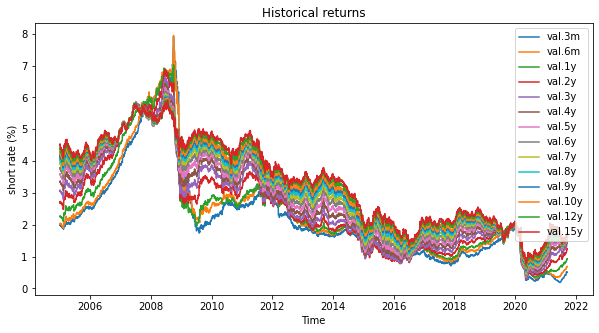

In [159]:
df_final = df_final.iloc[0:-2,:] #remove last row

#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(df_final.iloc[:,0], df_final.iloc[:,1:] ,label=df_final.columns[1:])
plt.title('Historical returns')
plt.ylabel("short rate (%)")
plt.xlabel("Time")
plt.legend()
plt.show()

#print(df_final) #mangler 15års renten...ups

# HJM framwork: Heath-Jarrow-Morton Model

Modellerer forward interest rates ( =  en rate settes i dag for et lån som skal inngås i fremtiden t med maturity date T.)

$$ df(t,T) = \mu ( t, T ) dt + \sigma (t, T) dW(t) $$

hvor $df(t,T)$: forward rente på zero-copoun obligasjon med maturity T, og W er browniam motion (random walk).

$\mu$ er drift-funksjon og $\sigma$ er volatilitetsfunksjon.

Den predikerer forward renter basert på summen av drift og diffusjon.

Volatilitetsfunksjonen for $df(t,T)$ er 

$$ v(t,T) = -\frac{\partial}{\partial T} \sigma(t,T)$$

Setter drift term $\mu(t,T)$ lik spot renten $r(t) = f(t,t)$ slik at vi får 

$$df(t,T) = \Big(v(t,T)^T \int_{t}^{T}v(t,s)ds\Big)dt + v(t,T)^T dW$$

Vi approksimerer likningen med diskretisering på et time grid.

### Finn forward rates

Først finner vi diskoteringsfaktoren for å nåverdien av fremtidig cash flow. Dette er den diskrete compunded interest rate. Den er gitt ved:

$$ DF = (1+r)^{-t} $$

der r er kortrenten, og t er tidsperioden angitt i år. 

Forward $f(t,T)$ angir renten for tiden t for lån gitt på tiden $T$ som er tilbakebetalt en instant seinere i fremtiden. Renten er definert utifra zero coupon bond,

$$ f(t,T ) = - \frac{\partial }{\partial T} \log B(t,T)$$

I praksis er $B(t,T)$ sjelden kontinuerlig for $T$ og vi kan diskretisere den deriverte mellom tidsperioden $t_a$ og $t_b$ ved diskretisering av short-renten / spot renten: 


$$ f(t, T) = \frac{log(r_a/r_b)}{t_b-t_a} $$

Short-rate er den korteste mulige renten på et tidspunkt og ved grensen T-t er $f(t,t)$ lik $r(t)$


In [160]:
#maturity dates
tau = [3/12,6/12,1,2,3,4,5,6,7,8,9,10,12,15]

#finn diskoteringsrenten: determine the present value of future cash flows
def discountRate(r, t):
    return (1+r/100)**(-t)

#forward rate mellom to nabo-renter, altså mellom 3mnd renten og 6mnd renten osv.
fwd_data = np.zeros((df_final.shape[0],df_final.shape[1]-2))

for row in range(df_final.shape[0]):
    for col in range(df_final.shape[1]-2): #fjern dato kolonne og 15åringen
        t_a = tau[col]
        t_b = tau[col+1]
        r_a = discountRate(df_final.iloc[row,col+1], t_a)
        r_b = discountRate(df_final.iloc[row,col+2], t_b)
        fwd_rate = (np.log(r_a/r_b)*(1/(t_b-t_a)))
        fwd_data[row, col] = fwd_rate*100

In [161]:
#column labels based on the start date of the future rates
names = ["3mnd", "6mnd", "1y", "2y", "3y", "4y", "5y", "6y", "7y", "8y", "9y", "10y", "12y"]
df_fwd = pd.DataFrame(df_final["dates"])
for col in range(len(fwd_data[0])):
    df_fwd.insert(col+1,names[col],fwd_data[:,col])


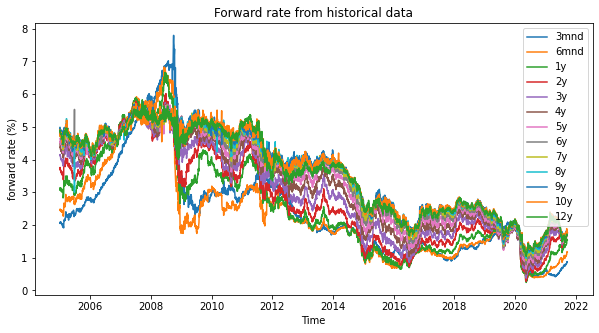

In [168]:
#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(df_fwd["dates"], df_fwd.iloc[:,1:] ,label=df_fwd.columns[1:])
plt.title('Forward rate from historical data')
plt.ylabel("forward rate (%)")
plt.xlabel("Time")
plt.legend()
plt.show()

Kode inspirert av: https://github.com/omartinsky/HJM/blob/main/hjm.ipynb

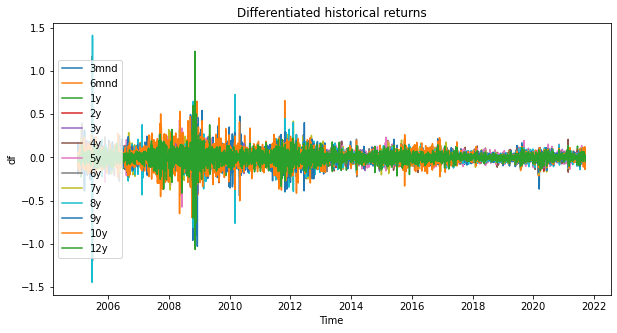

In [169]:
diff_rates = df_fwd.iloc[:,1:].diff( axis=0)
diff_rates = diff_rates.iloc[1:nrows-2,:] #delete first row
dates = df_fwd.iloc[0:-1,0]
#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(dates, diff_rates, label=diff_rates.columns)
plt.title('Differentiated historical returns')
plt.ylabel("df")
plt.xlabel("Time")
plt.legend()
plt.show()

###  Principal Component Analysis


For å finne volatilitetsfaktorene i HJM-modellen starter vi med å finne de tre første prinsipialkomponentene av de historiske forward rentene. PCA brukes til å identifisere felles faktorer i rentene ved å lineært transformere data punktene vi har til ortogonale prinsipialkomponenter.

$$ \Sigma = V \Lambda V^T$$

hvor $\Sigma$ er kovariansmatrisen til dataen, $V$ er egenvektorer og $\Lambda$ en diagonalmatrisen med egenverdiene $\lambda_i$.

Volatilitetsfaktorene blir funnet ved å lineært interpolere hver av egenvektorene (vi velger ut 3 stk) og skalere funksjonene med roten av den tilhørende egenverdien og antall dager i et år (252) for å skalere dataen fra dager til år: 

$$ v(t_i, t_j) = \sqrt{252\lambda_k}$$


In [ ]:
# Calculate covariance matrix
sigma = np.cov(diff_rates.transpose())
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (13, 13)


In [ ]:
sigma *= 252 #annulize daily rates

In [ ]:
#calculate eigenvalues and vectors
eigval, eigvec = np.linalg.eig(sigma)
eigvec=np.matrix(eigvec)
print(eigval)

[3.72386269 1.56150837 1.0879736  0.1519044  0.88646711 0.80981046
 0.26971688 0.32563778 0.3454551  0.48908336 0.58756472 0.6040632
 0.64245326]


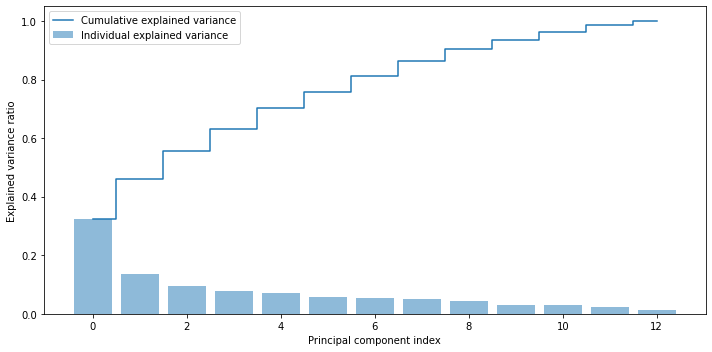

In [ ]:
# Determine explained variance
total_eigval = sum(eigval)
var_exp = [(i/total_eigval) for i in sorted(eigval, reverse=True)]
var_exp

plt.figure(figsize=(10,5))
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Principal eigenvalues
[3.72386269 1.56150837 1.0879736 ]

Principal eigenvectors
         1PC       2PC       3PC
0   0.050159  0.061338  0.098409
1   0.140596 -0.063439 -0.063445
2   0.239406  0.049151  0.062951
3   0.265843  0.009914  0.000094
4   0.288945 -0.006022 -0.020759
5   0.306875  0.018538 -0.016382
6   0.305547  0.079917  0.006174
7   0.283857  0.028803 -0.343805
8   0.288986  0.057150 -0.262263
9   0.309377  0.074062  0.845277
10  0.320696  0.310304 -0.279949
11  0.314911 -0.892497 -0.031159
12  0.341895  0.283747  0.027760


Text(0.5, 0, 'Time $t$')

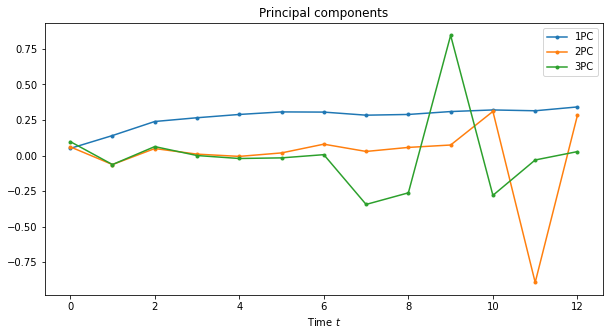

In [ ]:
#select eigenvectors with highest eigenvalues
factors = 3 # 3 PCs
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # highest principal component first in the array
princ_eigval = np.array([eigval[i] for i in index_eigvec])
princ_comp = np.hstack([eigvec[:,i] for i in index_eigvec]) #hver PC eggges kolonnevis i princ_comp
princ_comp_df = pd.DataFrame(princ_comp, columns= ["1PC", "2PC", "3PC"])
#print results
print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp_df)

#plot
plt.figure(figsize=(10,5))
plt.plot(princ_comp_df, marker='.', label=princ_comp_df.columns)
plt.title('Principal components')
plt.legend()
plt.xlabel(r'Time $t$')

Tolkning av de tre Prinsipialkomponentene: 

1st PC: Parallell shift in the yield curve

2nd PC: Change in slope of the yield curve

3rd PC: Twist in yield curve


vols shape: (13, 3)


Text(0.5, 1.0, 'Discretized volatilities')

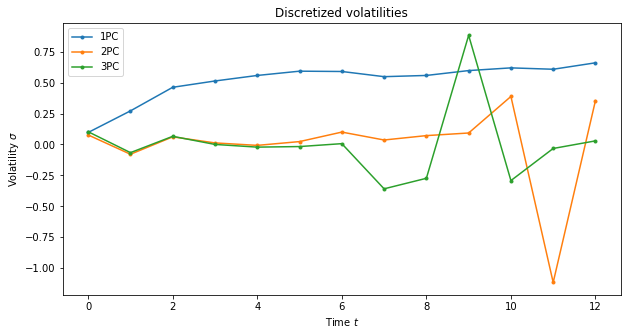

In [ ]:
#Calculate discretized volatility function from principal components¶
sqrt_eigval = np.matrix(princ_eigval ** .5) #roten av egenverdier
tmp_m = np.vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix og eigenvalues from (1,factors) to (n, factors)
vols = np.multiply(tmp_m, princ_comp) # multiply matrice element-wise
#vols_df = pd.DataFrame(vols, columns=["1PC", "2PC", "3PC"])

print('vols shape: ' + str(vols.shape))

#plot
plt.figure(figsize=(10,5))
plt.plot(vols, marker='.', label=princ_comp_df.columns)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Volatility $\sigma$')
plt.legend()
plt.title('Discretized volatilities')

# Volatility Fitting
We need to fit discretized volatility functions from the previous step using cubic interpolators. The reason is that these interpolators will be later integrated numerically in order to calculate risk-neutral drift.

In [ ]:
def get_matrix_column(mat, i): #return given column from matrix
    return np.array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    
    def __init__(self, params):
        self.params = params

    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = np.array([x**i for i in reversed(range(n))]) #matrix of polynomials of x
        return sum(np.multiply(X, C)) 

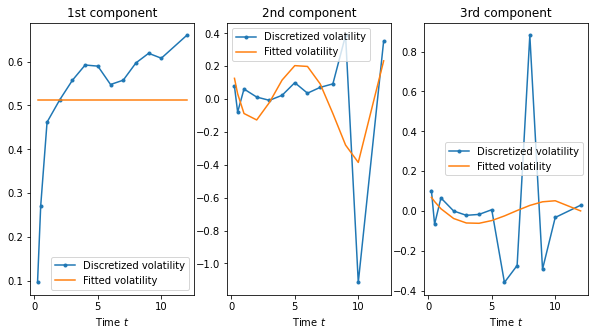

In [ ]:
fitted_vols = []
tenors = tau[0:-1]
def fit_volatility(i, degree, title): # i is giving index nr. of PC
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(np.polyfit(tenors, vol, degree))        
    plt.plot(tenors, vol, marker='.', label='Discretized volatility')
    plt.plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title)
    plt.xlabel(r'Time $t$')
    plt.legend()
    return fitted_vol


plt.figure(figsize=(10,5))

# We will approximate the first principal component with interpolator with 0 degree (straight line). This approximates well parallel movements of interest rates.   
plt.subplot(1, 3, 1)
fitted_vols.append(fit_volatility(0, 0, '1st component'))
# fitted_vol_try = PolynomialInterpolator([0.52])
# fitted_vols.append(fitted_vol_try)

# plt.plot(tenors, [fitted_vol_try.calc(x) for x in tenors], label='Harkodet fitted volatility')
# plt.legend()

# 2nd and 3rd principal component will be approximated using cubic interpolator with degree 3.
plt.subplot(1, 3, 2)
fitted_vols.append(fit_volatility(1, 4, '2nd component'))

plt.subplot(1, 3, 3)
fitted_vols.append(fit_volatility(2, 3, '3rd component'))


# Risk-neutral Drift Calculation
For å finne drift term må vi integrere volatilitetsfunksjonene vi fant ved interpolering. Vi finner integralet numerisk ved trapesregelen.

$$ \mu(t,T) = v(t,T)^T \int_{t}^{T}v(t,s)ds$$

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
[[ 0.51317381  0.24740437  0.09238995]
 [ 0.51317381 -0.08759469  0.01128469]
 [ 0.51317381 -0.12686502 -0.03767014]
 [ 0.51317381 -0.02075269 -0.06011337]
 [ 0.51317381  0.11587759 -0.06168382]
 [ 0.51317381  0.20364248 -0.04802032]
 [ 0.51317381  0.19864    -0.02476169]
 [ 0.51317381  0.09244955  0.00245324]
 [ 0.51317381 -0.08786814  0.02798565]
 [ 0.51317381 -0.27977092  0.0461967 ]
 [ 0.51317381 -0.38523532  0.05144758]
 [ 0.51317381 -0.27075649  0.03809945]
 [ 0.51317381  0.23265179  0.0005135 ]]


Text(0.5, 1.0, 'Volatilities')

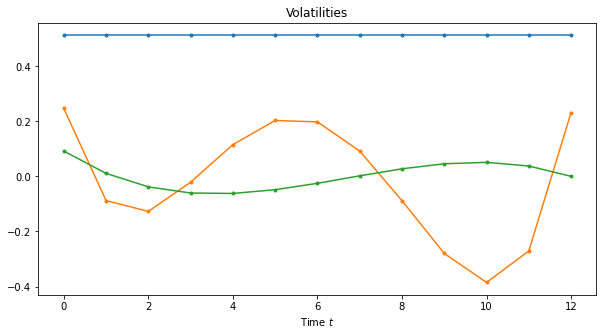

In [ ]:
#make equally spaced points for xaxis
mc_tenors = np.linspace(0,12,len(tenors)) #equally spaced points giving the tenors
print(mc_tenors)
print(tenors)

# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols = np.matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()
print(mc_vols)

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, mc_vols, marker='.')
plt.xlabel(r'Time $t$')
plt.title('Volatilities')

In [ ]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(np.linspace(x0, x1, int(n))):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out


def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

Text(0.5, 1.0, 'Risk-neutral drift')

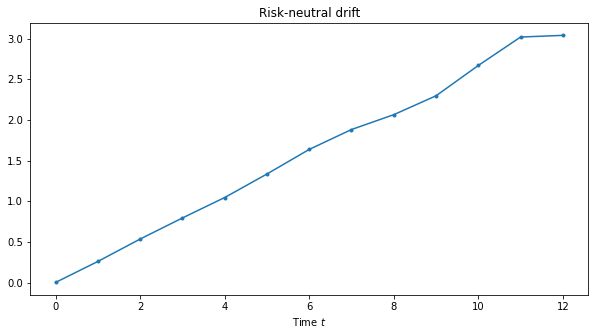

In [ ]:
mc_drift = np.array([m(tau, fitted_vols) for tau in mc_tenors])

plt.figure(figsize=(10,5))
plt.plot(mc_drift, marker='.')
plt.xlabel(r'Time $t$')
plt.title('Risk-neutral drift')

# Monte Carlo Simulation



Text(0.5, 0, 'T (maturity date)')

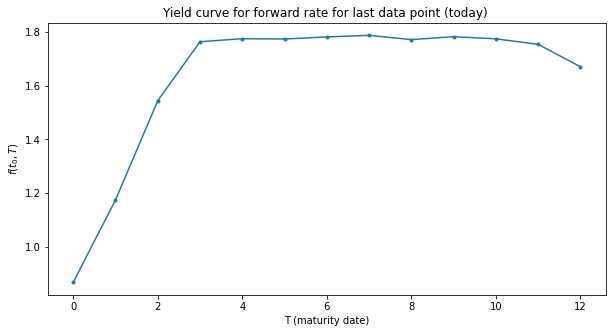

In [ ]:
# finn start-forward rate for hver rente
f0 = np.array(np.matrix(df_fwd.iloc[-1,:]).flatten())[0] #tar første element for å bli kvitt dobbel liste
f0 = f0[1:]

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, f0.transpose(), marker='.')
plt.ylabel('$f(t_0,T)$')
plt.title("Yield curve for forward rate for last data point (today) ")
plt.xlabel("T (maturity date)")


In [172]:
import copy

def simulation(f, tenors, drift, vols, timeline): # f er startverdien for forward renten
    vols = np.array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copy.copy(f)

    for it in range(1, len(timeline)):                  # it er indeks for hver x-verdi (dato i fremtiden)
        t = timeline[it]                                # t angir år frem i tid.
        dt = t - timeline[it-1]                         # dt angir tidsintervall fra sist iterasjon
        sqrt_dt = np.sqrt(dt)
        fprev = f
        f = copy.copy(f)
        random_numbers = [np.random.normal() for i in range(len_vols)] #dX_i er std.normal fordelt og vi har 3 stk ( = #PC)

        for iT in range(len_tenors):                    # for hver maturity                       
            val = fprev[iT] + drift[iT] * dt            # hent ut første del av df + f
            #
            summ = 0
            for iVol, vol in enumerate(vols):           # iterer gj. sum av volatiliteter
                summ += vol[iT] * random_numbers[iVol]  # random_numbers gir dX_i
            val += summ * sqrt_dt                       # legg til siste ledd på df + f 
                                                        # brownian motion er std.normal*swrt(dt)
            
            #på siste tenor-punkt (maturity)
            iT1 = iT+1 if iT < len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT) #Musela HJM SDE 
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

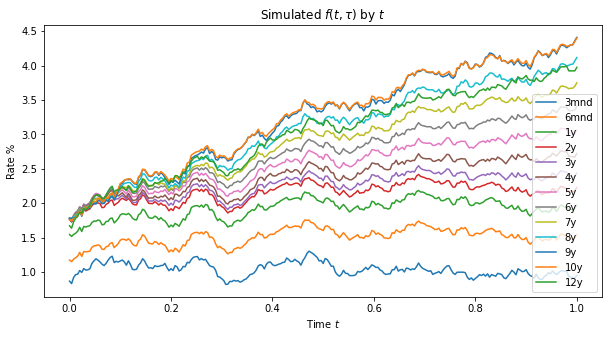

In [183]:
proj_rates = []
proj_timeline = np.linspace(0,1,251) # 1 år frem i tid med 500 tidspunkter

# looper over tidsperioden vi skal simulere
# i er indeks, 
# t er tidspunkt gitt i år, 
# f er en vektor av forward rates for de ulike maturities
for i, (t, f) in enumerate(simulation(f0, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    proj_rates.append(f)

proj_rates_df = pd.DataFrame(proj_rates)
proj_rates_df.columns = names
#proj_rates består av en kolonne per maturity og hver rad er et tidsintervall simulert frem  i tid
proj_rates = np.matrix(proj_rates)

plt.figure(figsize=(10,5))
plt.plot(proj_timeline.transpose(), proj_rates_df, label=proj_rates_df.columns)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Rate %')
plt.title(r'Simulated $f(t,\tau)$ by $t$')
plt.legend()
plt.show()


Den første figuren viser en simulering av forward renten fra siste dag i datasettet og 1 år frem i tid der hver linje er for de ulike maturity datoene. Vi har simulert for 251 tidspunkter for et år frem i tid, angir ca. en simulering per dag.

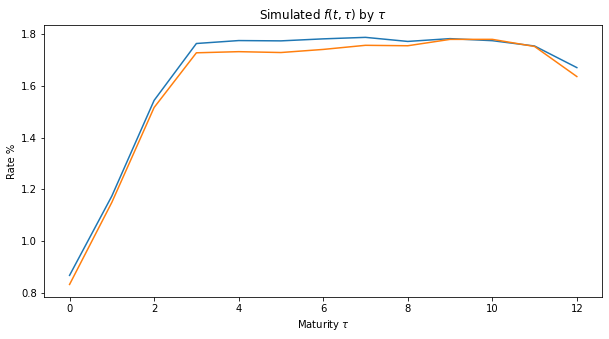

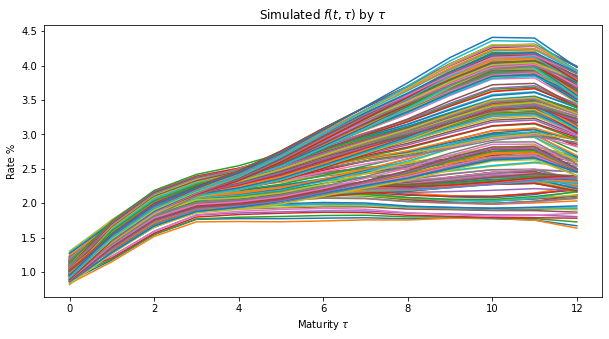

In [188]:

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, np.array(proj_rates.transpose()[:,0:2]))
plt.xlabel(r'Maturity $\tau$')
plt.ylabel(r'Rate %')
plt.title(r'Simulated $f(t,\tau)$ by $\tau$')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, proj_rates.transpose())
plt.xlabel(r'Maturity $\tau$')
plt.ylabel(r'Rate %')
plt.title(r'Simulated $f(t,\tau)$ by $\tau$')
plt.show()

Neste plot viser fordelingen av forward renten etter et år av simulering over hver av maturityene angitt i år. Vi ser i første plot som viser de to første simuleringene (to første dagene) at kurven har flyttet seg en enhet df, altså forward renten øker noe.

Vi ser også at det er intervallet vokser for høyere maturity date, det gir mening at denne er mer volatil og vanskeligere å modellere. 

In [210]:
# def zcb_price(f_t, t_a, t_b):
#     return np.exp(-f_t*(t_b-t_a))

# def zero_coupon_bond(r, t, par=1):
#     # t: time to maturity
#     # r is simulated interest rate
#     # par is par value, set to 1
#     return par/(1+r)**t


# #for 3 mnd renten
# price = np.zeros(len(proj_rates[:,0]))
# t= 0
# for i in range(0,len(proj_rates[:,0])):
#     r = proj_rates[i,0]
    
#     price[i] = ( zcb_price(r,1,0))

# print(np.mean(price))


2.8397616044347633
